# Test Systems

Uses REBOUND commit 25f856dc2f79e0ad17b2f6bd604225f550593376

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper')
%matplotlib inline

In [2]:
if rebound.__githash__ != '25f856dc2f79e0ad17b2f6bd604225f550593376':
    print('Should checkout commit above to ensure this runs correctly')

Should checkout commit above to ensure this runs correctly


In [3]:
system = 'nonressystems/Kepler-446/'
datarepopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/'

In [4]:
def systeminfo(system):
    sapath = datarepopath + 'data/' + system + 'simulation_archives/runs/'
    sa = rebound.SimulationArchive(sapath+'sa0000001.bin')
    sim = sa[0]
    
    ps = sim.particles
    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3./ps[0].m)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3./ps[0].m)**(1./3.)
    beta12 = (ps[2].a-ps[1].a)/Rhill12
    beta23 = (ps[3].a-ps[2].a)/Rhill23
    P12 = ps[2].P/ps[1].P
    P23 = ps[3].P/ps[2].P
    print("P2/P1 = {0}\nP3/P2 = {1}\na2-a1 = {2} RH_12\na3-a2 = {3} RH_23".format(P12, P23, beta12, beta23))
    fig = rebound.OrbitPlot(sim)

P2/P1 = 1.9395046625940953
P3/P2 = 1.6958321133757708
a2-a1 = 17.830745989332478 RH_12
a3-a2 = 14.929810416733591 RH_23


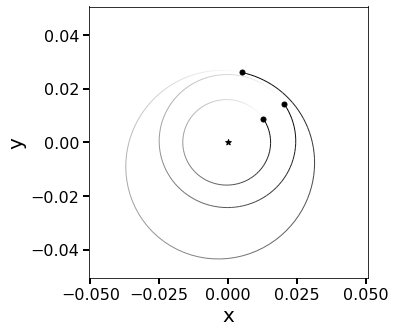

In [5]:
systeminfo(system)

In [6]:
def get_k(row, system):
    sapath = datarepopath + 'data/' + system + 'simulation_archives/runs/'
    sa = rebound.SimulationArchive(sapath+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    return row

In [7]:
def plot_system(system, model, features, featurefolder, threshold, ax1, ax2):
    trainpath = repopath+'training_data/' + system + featurefolder
    labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
    # Create k and h columns for plotting
    labels['k'] = 0.
    labels['h'] = 0.
    dasklabels = dd.from_pandas(labels, npartitions=24)
    dasklabels = dasklabels.apply(get_k, system=system, axis=1, meta=labels).compute(scheduler='processes')
    
    # Make predictions on the simulations using passed model
    tdata = pd.read_csv(trainpath + 'trainingdata.csv', index_col=0)
    if features is None:
        features = tdata.columns.values
    tdata = tdata[features]
    proba = model.predict_proba(tdata[features])[:,1]
    
    stablemask = dasklabels['Stable'] == True
    unstablemask = dasklabels['Stable'] == False
    pstablemask = proba > threshold
    punstablemask = proba < threshold
    TPR = ((pstablemask == stablemask) & stablemask).sum()/stablemask.sum()
    TNR = ((pstablemask == stablemask) & unstablemask).sum()/unstablemask.sum()
    fracagree = (pstablemask == stablemask).sum()/stablemask.shape[0]
    
    colorbar = 'winter'
    cmap = matplotlib.cm.get_cmap(colorbar)
    s=20
    ax1.scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
    ax1.scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
    ax2.scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
    ax2.scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
    ax2.tick_params(axis='y', which='both', left='off', right='off')
    ax1.text(-0.25, 0.3, system.split('/')[1], weight='bold', size=24, color='red')
    ax2.text(-0.2, 0.3, 'TPR = {0:.1f}%'.format(TPR*100), fontsize=16)
    ax2.text(-0.2, 0.22, 'TNR = {0:.1f}%'.format(TNR*100), fontsize=16)
    ax2.text(-0.2, 0.14, '% agree = {0:.1f}%'.format(fracagree*100), fontsize=16)

In [8]:
def ttvsystems():
    folders = ['KOI-0115', 'KOI-0168', 'KOI-0085', 'KOI-0156', 'KOI-1576', 'KOI-2086', 'KOI-0314']
    return ['TTVsystems/' + folder + '/' for folder in folders]

def nonressystems():
    folders = ['Kepler-431', 'EPIC-210897587-2', 'Kepler-446', 'LP-358-499']
    return ['nonressystems/' + folder + '/' for folder in folders]

In [9]:
def plotsystems(systems, model, features, featurefolder, threshold, modelfile):
    Nsystems = len(systems)
    Nrows = int(np.ceil(Nsystems/2)) # 2 systems per row 
    # 2 systems per row* 2 panels (Nbody, XGboost) = 4 columns
    f, axarr = plt.subplots(Nrows,4, figsize=[16, 4*Nrows], sharex=True, sharey=True)

    for i, system in enumerate(systems):
        row1 = 2*i//4
        col1 = 2*i%4
        row2 = (2*i+1)//4
        col2 = (2*i+1)%4
        plot_system(system, model, features, featurefolder, threshold, axarr[row1,col1], axarr[row2,col2])
        
    scale = 0.4
    for ax in axarr.flat:
        ax.set_ylim([-scale, scale])
        ax.set_xlim([-scale, scale])

    for ax in axarr[:,0]: # ylabel on first column
        ax.set_ylabel(r'$e_y$') 
    for ax in axarr[1,:]: # xlabel on bottom row
        ax.set_xlabel(r'$e_x$') 

    axarr[0,0].set_title("Nbody")
    axarr[0,1].set_title("ML model")
    axarr[0,2].set_title("Nbody")
    axarr[0,3].set_title("ML model")
    axarr[0,0].legend(loc='lower left')
    
    axarr[Nrows//2, 1].set_title(modelfile, fontsize=24)
    axarr[Nrows//2, -1].set_title('thresh={0}'.format(threshold), fontsize=24)
    plt.subplots_adjust(wspace=0)
    plt.savefig(modelfile+"NbodyvsML"+systems[0].split('/')[0]+".png", bbox_inches="tight")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

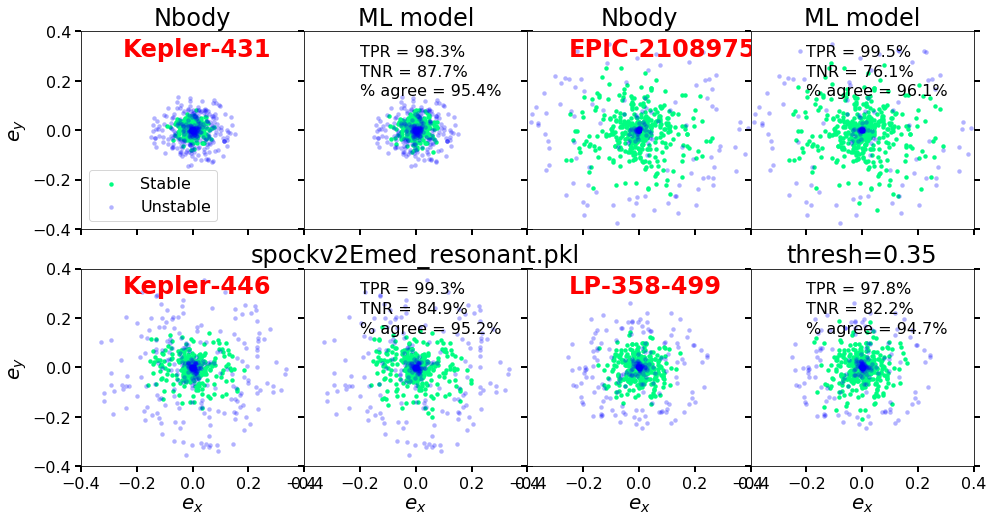

In [10]:
modelfile = 'spockv2Emed_resonant.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.35
systems = nonressystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

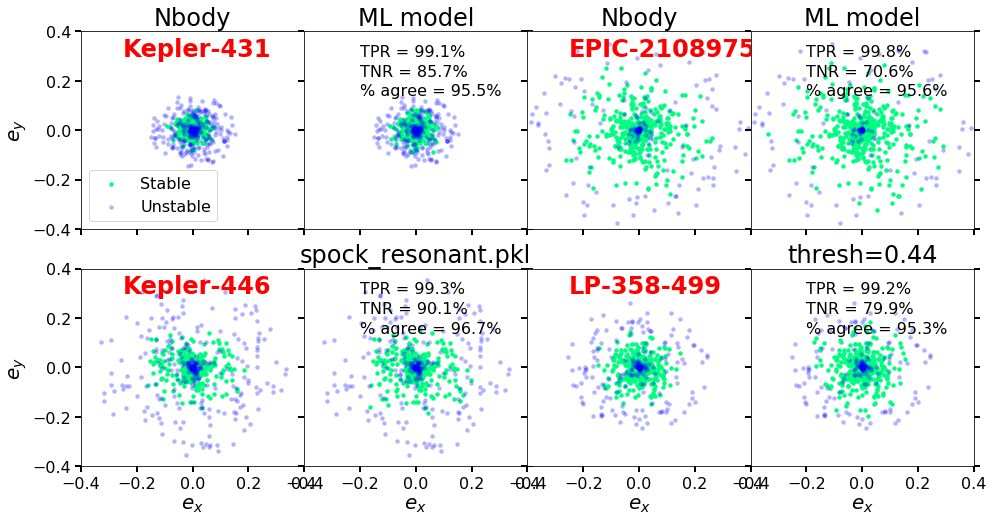

In [53]:
modelfile = 'spock_resonant.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.44
systems = nonressystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

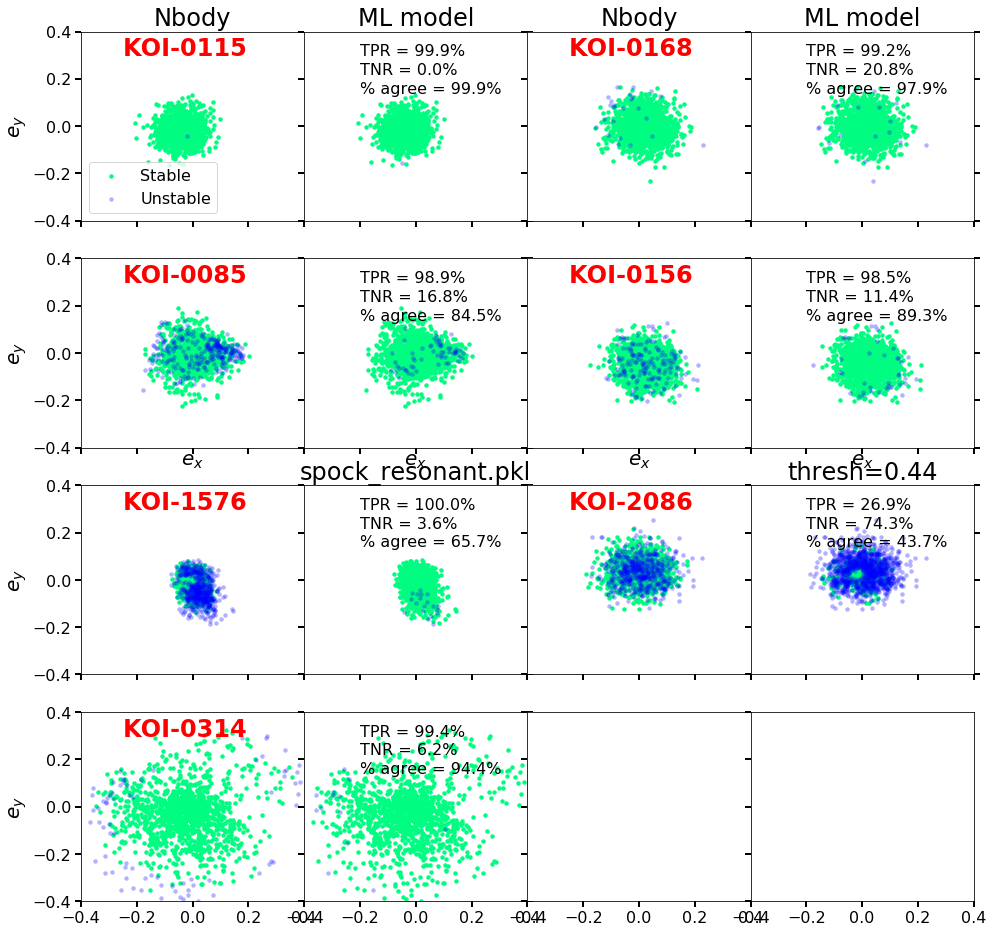

In [52]:
modelfile = 'spock_resonant.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.44
systems = ttvsystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

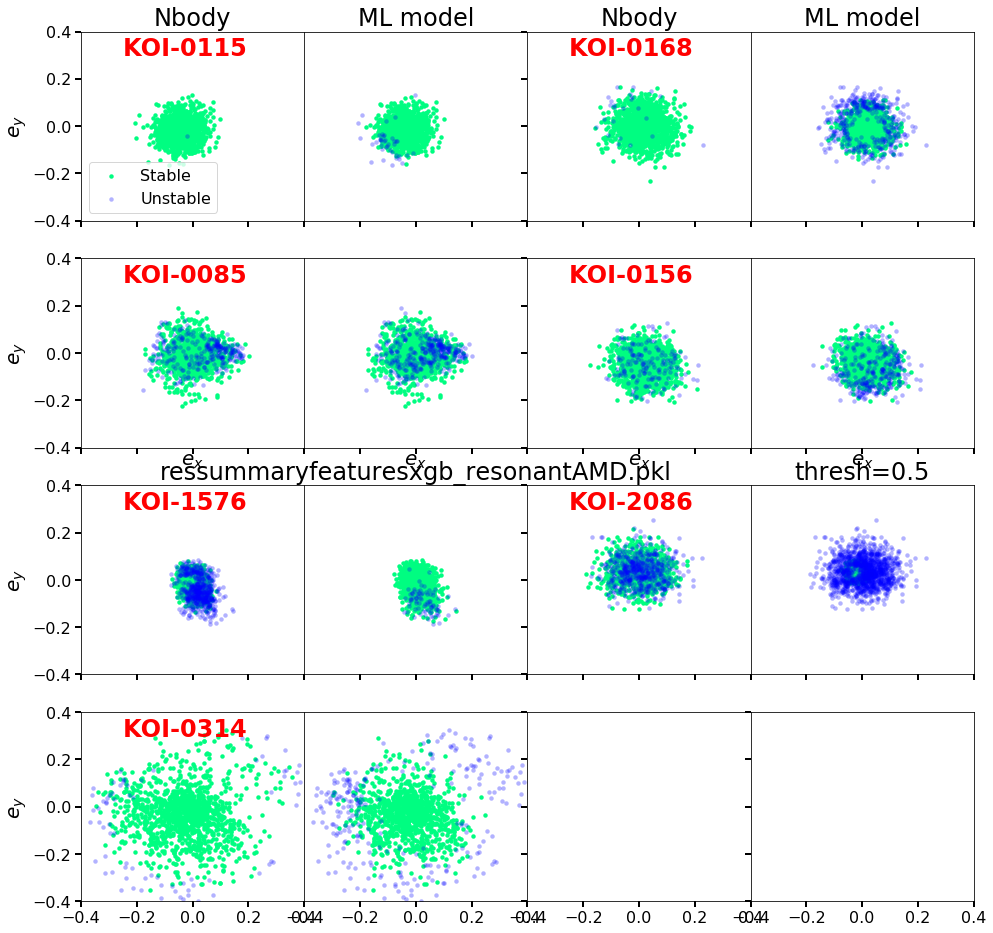

In [63]:
modelfile = 'ressummaryfeaturesxgb_resonantAMD.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.85
systems = ttvsystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)

In [60]:
featurefolder

'ressummaryfeaturesxgbNorbits10000.0Nout1000/'